In [2]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install librosa
!pip install SoundFile
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.9 MB/s eta 0:00:00


In [3]:
import numpy as np
print(np.__version__)

1.26.4


In [44]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1TjujGTMC98a4d0smt0D8Ff3ohDOtJzEk"})
downloaded.GetContentFile('Colab_Data.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Colab_Data.zip', 'r') as zip_file:
    zip_file.extractall()

In [5]:
import librosa
print(librosa.__version__)
import glob
import os
import pandas as pd
from xml.dom import minidom
from scipy import signal
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import random
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.patches as patches

0.10.2.post1


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Paths
annotations_path = './Colab_Data/Annotations/'
my_annotations_path = '/content/drive/MyDrive/Project_Ecology/Annotation/'

original_audio_path = './Colab_Data/Audio/'
my_audio_path =  '/content/drive/MyDrive/Project_Ecology/Audio/'
downsampled_audio_path ='./Colab_Data/Downsampled_Audio/'

audio_files = sorted([f for f in os.listdir(my_audio_path) if f.endswith('.WAV')])
annotation_files = sorted([f for f in os.listdir(my_annotations_path) if f.endswith('.svl')])
audio_ids = [os.path.splitext(f)[0] for f in audio_files]
annotation_ids = [os.path.splitext(f)[0] for f in annotation_files]
my_train_file = pd.DataFrame({
    'file_id': audio_ids
})
csv_path = '/content/drive/My Drive/train_file.csv'
my_train_file.to_csv(csv_path, index=False, header=False)
train_file='/content/drive/My Drive/train_file.csv'

species_folder = './'
file_type = '.svl'
audio_extension = '.WAV'
training_files = './Colab_Data/train_multi.csv'


# Data hyper-parameters
# -----------------------------
downsample_rate = 16000
segment_duration = 5.0


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 2048
hop_length = 512
n_mels = 128

# To decide on these, you might want to work on a single audio file
# to figure out what are suitable values so that you can see the different events
# you might want to work in conjunction with SonicVisualiser + loaded annotations
# for a particular file

In [8]:
# You most likely will not modify this
def get_annotation_information(annotation_path,file_name, audio_amps, sample_rate):

  # Process the .svl xml file
  xmldoc = minidom.parse(annotation_path+file_name+'.svl')
  itemlist = xmldoc.getElementsByTagName('point')
  idlist = xmldoc.getElementsByTagName('model')

  start_time = []
  end_time = []
  labels = []
  audio_file_name = ''

  print ('get annotation information')

  if (len(itemlist) > 0):

      print(file_name)

      # Iterate over each annotation in the .svl file (annotatation file)
      for s in itemlist:

          # Get the starting seconds from the annotation file. Must be an integer
          # so that the correct frame from the waveform can be extracted
          start_seconds = float(s.attributes['frame'].value)/sample_rate
          print('start_seconds', start_seconds)

          # Get the label from the annotation file
          label = str(s.attributes['label'].value)

          # If a file has a blank label then skip this annotation
          # to avoid mislabelling data
          if label == '':
              break

          # Get the duration from the annotation file
          annotation_duration_seconds = float(s.attributes['duration'].value)/sample_rate
          start_time.append(start_seconds)
          end_time.append(start_seconds+annotation_duration_seconds)
          labels.append(label)

  df_annotations = pd.DataFrame({'Start': start_time, 'End':end_time ,'Label': labels})
  return df_annotations, file_name+'.wav'

In [9]:
def read_audio_file(file_name):
    audio_path = os.path.join(original_audio_path, file_name)
    audio_amplitudes, sample_rate = librosa.load(audio_path+audio_extension, sr=None)
    return audio_amplitudes, sample_rate

In [10]:
# You most likely will not modify this
def getXY(audio_amplitudes, start_sec, annotation_duration_seconds,
          labels, sample_rate, verbose):

    if verbose == True:
        print ('start_sec', start_sec)
        print ('annotation_duration_seconds', annotation_duration_seconds)
        print ('segment_duration ', segment_duration )

    X_segments = []
    Y_labels = []

    # Calculate how many segments can be extracted based on the duration of
    # the annotated duration. If the annotated duration is too short then
    # simply extract one segment. If the annotated duration is long enough
    # then multiple segments can be extracted.
    if annotation_duration_seconds-segment_duration < 0:
        segments_to_extract = 1
    else:
        segments_to_extract = int(annotation_duration_seconds - segment_duration + 1)

    if verbose:
        print ("segments_to_extract", segments_to_extract)

    for i in range (0, segments_to_extract):
        if verbose:
            print ('Semgnet {} of {}'.format(i, segments_to_extract-1))
            print ('*******************')

        # Set the correct location to start with.
        # The correct start is with respect to the location in time
        # in the audio file start+i*sample_rate
        start_data_observation = int(start_sec*sample_rate+i*(sample_rate))

        # The end location is based off the start
        end_data_observation = int(start_data_observation + (sample_rate*segment_duration))

        # This case occurs when something is annotated towards the end of a file
        # and can result in a segment which is too short.
        if end_data_observation > len(audio_amplitudes):
            continue

        # Extract the segment of audio
        X_audio = audio_amplitudes[start_data_observation:end_data_observation]

        if verbose == True:
            print ('start frame', start_data_observation)
            print ('end frame', end_data_observation)

        # Extend the segments and labels
        X_segments.append(X_audio)
        Y_labels.append(labels)

    return X_segments, Y_labels

In [11]:
file_name = '20241112_030900_AIMS'
audio, sample_rate = read_audio_file(file_name)
df_annotations, file_name = get_annotation_information(annotations_path,file_name, audio, sample_rate)
df_annotations

get annotation information
20241112_030900_AIMS
start_seconds 3.6773333333333333
start_seconds 10.789333333333333
start_seconds 11.2
start_seconds 21.82133333333333
start_seconds 28.634666666666668
start_seconds 30.14666666666667
start_seconds 32.218666666666664
start_seconds 34.608
start_seconds 41.44
start_seconds 48.010666666666665
start_seconds 48.029333333333334
start_seconds 52.17333333333333
start_seconds 59.77066666666666
start_seconds 60.498666666666665
start_seconds 67.424
start_seconds 82.97333333333333
start_seconds 90.98133333333334
start_seconds 100.89333333333333
start_seconds 196.336
start_seconds 207.16266666666667
start_seconds 208.264
start_seconds 211.13866666666667
start_seconds 216.86933333333334
start_seconds 228.85333333333332
start_seconds 238.18666666666667
start_seconds 340.6666666666667
start_seconds 454.888
start_seconds 683.816
start_seconds 686.504
start_seconds 788.1813333333333
start_seconds 788.2933333333333
start_seconds 853.272
start_seconds 853.44
s

,Start,End,Label
0,3.677333,6.440000,b
1,10.789333,16.352000,b
2,11.200000,12.842667,a
3,21.821333,25.517333,b
4,28.634667,29.829333,b
5,30.146667,31.640000,a
6,32.218667,42.466667,a
7,34.608000,37.800000,b
8,41.440000,43.512000,b
9,48.010667,49.952000,b


In [12]:
import pandas as pd
from itertools import chain

def process_overlaps(df, mlb):

    # Sort annotations by start time
    df = df.sort_values(by="Start").reset_index(drop=True)

    # list to store all split intervals and labels
    events = []

    # iterate over each row
    for _, row in df.iterrows():
        start, end, label = row["Start"], row["End"], row["Label"]

        events.append((start, end, [label]))

    events = sorted(events, key=lambda x: x[0])

    combined_events = []
    current_start, current_end, current_labels = events[0]

    for event_start, event_end, event_labels in events[1:]:
        if event_start < current_end:  # means there exists overlap
            if event_start > current_start:
                #non-overlapping segment before overlap
                combined_events.append((current_start, event_start, current_labels))
            #overlapping segment
            overlap_start = max(current_start, event_start)
            overlap_end = min(current_end, event_end)
            combined_labels = list(set(current_labels) | set(event_labels))
            combined_events.append((overlap_start, overlap_end, combined_labels))
            current_labels = current_labels if current_end >= event_end else event_labels
            current_start = overlap_end
            current_end = max(current_end, event_end)
            # current_labels = event_labels
        else:  # there is no overlap
            combined_events.append((current_start, current_end, current_labels))
            current_start, current_end, current_labels = event_start, event_end, event_labels

    # add the final segment
    combined_events.append((current_start, current_end, current_labels))


    combined_df = pd.DataFrame(combined_events, columns=["Start", "End", "Labels"])

    # encodage
    combined_df["Labels"] = mlb.fit_transform(combined_df["Labels"]).tolist()
    label_columns = mlb.classes_
    for i, label in enumerate(label_columns):
        combined_df[label] = combined_df["Labels"].apply(lambda x: x[i])

    combined_df = combined_df.drop(columns=["Labels"])


    return combined_df


In [13]:
mlb = MultiLabelBinarizer(classes=["a", "b", "n", "w"])

multi_label_df = process_overlaps(df_annotations, mlb)
multi_label_df

,Start,End,a,b,n,w
0,3.677333,6.440000,0,1,0,0
1,10.789333,11.200000,0,1,0,0
2,11.200000,12.842667,1,1,0,0
3,12.842667,16.352000,0,1,0,0
4,21.821333,25.517333,0,1,0,0
5,28.634667,29.829333,0,1,0,0
6,30.146667,31.640000,1,0,0,0
7,32.218667,34.608000,1,0,0,0
8,34.608000,37.800000,1,1,0,0
9,37.800000,41.440000,1,0,0,0


In [14]:
def create_dataset(verbose, mlb,annotations_path, original_audio_path, training_files):

        # Initialise lists to store the X and Y values
        X_calls = []
        Y_calls = []

        if verbose == True:
            print ('Annotations path:',annotations_path+"*.svl")
            print ('Audio path',original_audio_path+"*.wav")

        # Read all names of the training files
        training_file_names = pd.read_csv(training_files, header=None)

        # Iterate over each annotation file
        for training_file in training_file_names.values:

            filename = training_file[0]

            print ('Processing file:',filename)

            print('Looking for this file: ', original_audio_path+filename+audio_extension)
            print('From these files here: ', original_audio_path+"*"+audio_extension)

            # Check if the .wav file exists before processing
            if original_audio_path+filename+audio_extension  in glob.glob(original_audio_path+"*"+audio_extension):
                print('Found file')

                # Read audio file
                # To do
                original_sample_rate = 48000
                signal, sample_rate = librosa.load(original_audio_path+filename+audio_extension,sr=None)
                signal_downsampled = librosa.resample(signal, orig_sr=sample_rate, target_sr=downsample_rate)


                # Get the start/stop time of each annotated event
                df, audio_file_name = get_annotation_information(annotations_path,filename , signal_downsampled,
                                                                 original_sample_rate)

                # The dataframe above will have a number of annotated events
                # each with a unique label. (i.e. not multi-label)
                # You need to combine these events
                # that overlap in time so that events with two or more labels
                # appear as a single row with the corresponding label
                # for example [1,1,0,0] means that event a and b happened.
                # Store the result in a variable called mult_label_df
                # as this will be a dataframe where you'll create a muli-label
                # dataset! Do not modify the name of this dataframe as it will
                # be used below, and you will be assessed on this.
                multi_label_df = process_overlaps(df, mlb)

                # You need to print this dataframe as you will be assessed on this
                print(multi_label_df)

                # At this point you would have a processed dataframe.
                # each row would be an acoustic event with one or more targets.
                # There are 4 possible targets
                # a, b, n and w
                # a = anthropohony (including human speech)
                # b = biophony
                # n = absence of sound event
                # w = wind
                # So example rows could be:
                # Start = 10, End = 12, a = 1, b= 0, n = 0, w= 1
                # Start = 20, End = 22, a = 0, b= 1, n = 0, w= 1
                # Start = 30, End = 32, a = 0, b= 1, n = 0, w= 0

                print('Reading annotations...')
                for index, row in multi_label_df.iterrows():

                    start_seconds = int(round(row['Start']))
                    end_seconds = int(round(row['End']))

                    # You might want to handle special cases where the current
                    # start window overlaps into another labelled event
                    # this happens when start + duration overlaps with the next event
                    # in the dataframe

                    # Note there is another special case, where the current event
                    # overlaps with the next, but the next event doesn't introduce
                    # new sounds, this you can include the next event

                    # Combine all the labels for this row
                    labels = [row['a'], row['b'], row['n'], row['w']]
                    annotation_duration_seconds = end_seconds - start_seconds

                    # Extract augmented audio segments and corresponding binary labels
                    X_data, y_data = getXY(signal_downsampled, start_seconds,
                                                annotation_duration_seconds,
                                           labels, downsample_rate, verbose)

                    # Append the segments and labels
                    X_calls.extend(X_data)
                    Y_calls.extend(y_data)
        # Convert to numpy arrays
        X_calls, Y_calls = np.asarray(X_calls), np.asarray(Y_calls)

        return X_calls, Y_calls

In [15]:
# Initialize MultiLabelBinarizer for binary encoding
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])

X1, Y1 = create_dataset(False, mlb,annotations_path,original_audio_path,training_files)
X2,Y2 = create_dataset(False, mlb,annotations_path=my_annotations_path,original_audio_path=my_audio_path,training_files=train_file)
X= np.concatenate([X1, X2], axis=0)
print(X2.shape, X2.shape)
Y = np.concatenate([Y1, Y2], axis=0)

Processing file: 20241112_030900_AIMS
Looking for this file:  ./Colab_Data/Audio/20241112_030900_AIMS.WAV
From these files here:  ./Colab_Data/Audio/*.WAV
Found file
get annotation information
20241112_030900_AIMS
start_seconds 3.6773333333333333
start_seconds 10.789333333333333
start_seconds 11.2
start_seconds 21.82133333333333
start_seconds 28.634666666666668
start_seconds 30.14666666666667
start_seconds 32.218666666666664
start_seconds 34.608
start_seconds 41.44
start_seconds 48.010666666666665
start_seconds 48.029333333333334
start_seconds 52.17333333333333
start_seconds 59.77066666666666
start_seconds 60.498666666666665
start_seconds 67.424
start_seconds 82.97333333333333
start_seconds 90.98133333333334
start_seconds 100.89333333333333
start_seconds 196.336
start_seconds 207.16266666666667
start_seconds 208.264
start_seconds 211.13866666666667
start_seconds 216.86933333333334
start_seconds 228.85333333333332
start_seconds 238.18666666666667
start_seconds 340.6666666666667
start_se

In [16]:
del X1, Y1, X2, Y2

In [17]:
# print the shape of X and Y
print(X.shape)
print(Y.shape)

(1581, 80000)
(1581, 4)


In [18]:
# Save to pickle file
# Save X and Y once this preprocessing step is done as this is time consuming!
import pickle
pickle_file = 'X_Y_data.pkl'
with open(pickle_file, 'wb') as f:
    pickle.dump((X, Y), f)
    print(f"Saved X and Y to {pickle_file}")

Saved X and Y to X_Y_data.pkl


In [19]:
# Load from pickle file to avoid running that pre-processing each time you want to run this script
with open(pickle_file, 'rb') as f:
    X, Y = pickle.load(f)

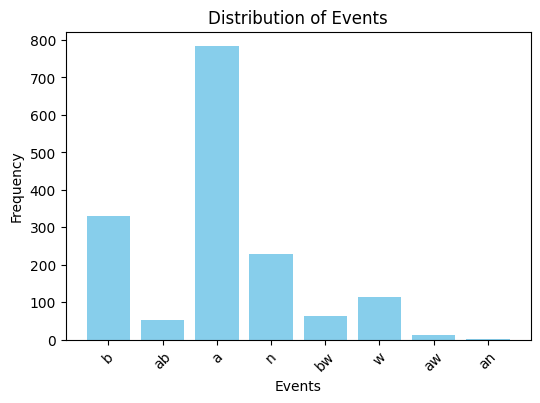

In [20]:
# Plot distribution of the different events. this includes events where there is more
# than one target!
import matplotlib.pyplot as plt
from collections import Counter

def plot_events_distribution(Y):
    labels = ['a', 'b', 'n', 'w']
    label_combinations = [''.join([labels[i] for i in range(len(row)) if row[i] == 1]) for row in Y]
    multi_label_counts = Counter(label_combinations)
    plt.figure(figsize=(6, 4))
    plt.bar(multi_label_counts.keys(), multi_label_counts.values(), color='skyblue')
    plt.xlabel('Events')
    plt.ylabel('Frequency')
    plt.title('Distribution of Events')
    plt.xticks(rotation=45)
    plt.savefig('events_distribution2.pdf')
    plt.show()
plot_events_distribution(Y)


In [21]:
def audio_to_spec(audio, n_fft, hop_length, n_mels):
    if len(audio) < n_fft:
        n_fft = len(audio)

    S = librosa.feature.melspectrogram(y=audio, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    img = librosa.core.power_to_db(S)

    img_np = np.asmatrix(img)
    img_scaled_temp = (img_np - np.min(img_np))
    img_scaled = img_scaled_temp / np.max(img_scaled_temp)

    mean = img.flatten().mean()
    std = img.flatten().std()
    eps = 1e-6
    norm = (img - mean) / (std + eps)

    min_val, max_val = norm.min(), norm.max()
    scaled = (norm - min_val) / (max_val - min_val)

    return scaled

def mel_specs(segments, n_fft, hop_length, n_mels):
    return np.array([audio_to_spec(segment, n_fft, hop_length, n_mels) for segment in segments])

X_spectrograms = mel_specs(X, n_fft, hop_length, n_mels)


In [22]:
X_spectrograms.shape

(1581, 128, 157)

In [23]:
# Save to pickle file
with open('X_spectrograms.pkl', 'wb') as f:
    pickle.dump(X_spectrograms, f)
    print("Spectrograms saved to X_spectrograms.pkl")

Spectrograms saved to X_spectrograms.pkl


In [24]:
# Load from pickle file to save time (next time you run the script)
with open('X_spectrograms.pkl', 'rb') as f:
    X_spectrograms = pickle.load(f)
    print("Spectrograms loaded from X_spectrograms.pkl")

Spectrograms loaded from X_spectrograms.pkl


In [25]:
# print the shapes of the spectrograms and targets
print(f"Shape of X_spectrograms: {X_spectrograms.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X_spectrograms: (1581, 128, 157)
Shape of Y: (1581, 4)


In [26]:
# # once you have spectrograms, you might want to delete  some old variables to save some RAM
del X
del multi_label_df

In [27]:
from sklearn.model_selection import train_test_split

seed = 123
X_train, X_val, Y_train, Y_val = train_test_split(X_spectrograms, Y, test_size=0.2, random_state=seed,
            shuffle=True)





In [28]:
# print shapes of training and validation data

print(f"Training data shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {Y_val.shape}")

Training data shape: (1264, 128, 157), (1264, 4)
Validation data shape: (317, 128, 157), (317, 4)


In [29]:
import numpy as np
import random
from collections import Counter


def time_shift(spec, max_shift=3):

    shift = random.randint(-max_shift, max_shift)
    shifted_spec = np.roll(spec, shift, axis=1)


    if shift > 0:
        shifted_spec[:, :shift] = 0
    elif shift < 0:
        shifted_spec[:, shift:] = 0

    return shifted_spec

def freq_mask(spec, max_freq_mask=6):
    spec_aug = np.copy(spec)
    if spec_aug.shape[0] > max_freq_mask:
        freq_mask_start = np.random.randint(0, spec_aug.shape[0] - max_freq_mask)
        spec_aug[freq_mask_start:freq_mask_start + max_freq_mask, :] = 0
    return spec_aug

def time_mask(spec, max_time_mask=10):

    spec_aug = np.copy(spec)
    if spec_aug.shape[1] > max_time_mask:
        time_mask_start = np.random.randint(0, spec_aug.shape[1] - max_time_mask)
        spec_aug[:, time_mask_start:time_mask_start + max_time_mask] = 0
    return spec_aug

def add_noise(spec, noise_factor=0.02):
    spec_aug = np.copy(spec)
    noise = np.random.normal(0, noise_factor, spec_aug.shape)
    spec_aug += noise
    return np.clip(spec_aug, 0, 1)
def balance_and_augment(X, Y, target_count, augmentation_methods):

    label_combinations = [''.join(map(str, row.astype(int))) for row in Y]
    combination_counts = Counter(label_combinations)
    augmented_data = []
    augmented_labels = []

    for label_comb, count in combination_counts.items():
        indices = [i for i, comb in enumerate(label_combinations) if comb == label_comb]
        current_data = [X[i] for i in indices]
        current_labels = [Y[i] for i in indices]

        augmented_data.extend(current_data)
        augmented_labels.extend(current_labels)


        if count < target_count:
            num_to_add = target_count - count
            for _ in range(num_to_add):
                original_idx = random.randint(0, len(current_data) - 1)
                augmented_spec = current_data[original_idx]


                augmentation_func = random.choice(augmentation_methods)
                augmented_spec = augmentation_func(augmented_spec)

                augmented_data.append(augmented_spec)
                augmented_labels.append(current_labels[original_idx])

        elif count > target_count:

            num_to_sample = min(target_count, len(current_data))
            indices_to_keep = random.sample(range(len(current_data)), num_to_sample)

            augmented_data.extend([current_data[i] for i in indices_to_keep])
            augmented_labels.extend([current_labels[i] for i in indices_to_keep])

    return np.array(augmented_data), np.array(augmented_labels)


augmentation_methods = [add_noise,time_shift,freq_mask,time_mask]


train_target_count = 2000


X_train_augmented, Y_train_augmented = balance_and_augment(
    X_train, Y_train, train_target_count, augmentation_methods
)



print(f"augmented X_train shape: {X_train_augmented.shape}, Y_train shape: {Y_train_augmented.shape}")


augmented X_train shape: (16000, 128, 157), Y_train shape: (16000, 4)


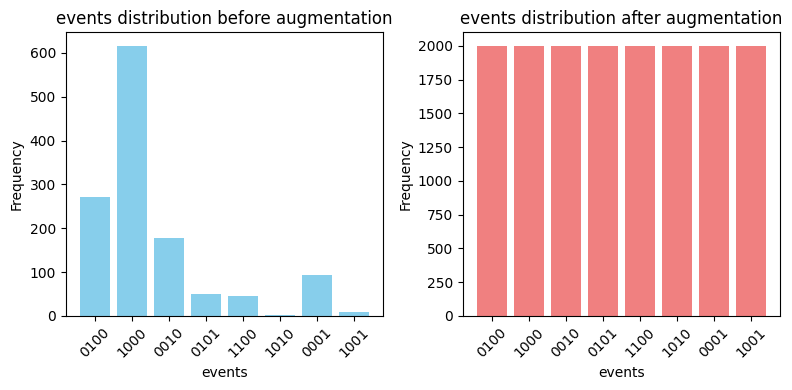

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(Y, title=""):
    label_combinations = [''.join(map(str, row.astype(int))) for row in Y]
    combination_counts = Counter(label_combinations)

    return combination_counts


plt.figure(figsize=(8, 4))

# before
plt.subplot(1, 2, 1)
combination_counts_before = plot_label_distribution(Y_train, title="")
plt.bar(combination_counts_before.keys(), combination_counts_before.values(), color='skyblue')
plt.xlabel('events')
plt.ylabel('Frequency')
plt.title("events distribution before augmentation")
plt.xticks(rotation=45)

# after
plt.subplot(1, 2, 2)
combination_counts_after = plot_label_distribution(Y_train_augmented, title="")
plt.bar(combination_counts_after.keys(), combination_counts_after.values(), color='lightcoral')
plt.xlabel('events')
plt.ylabel('Frequency')
plt.title("events distribution after augmentation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('events_distribution_before_after2.pdf')
plt.show()


Amount training dataset 16000
Amount validation dataset 317
training dataset event distribution:


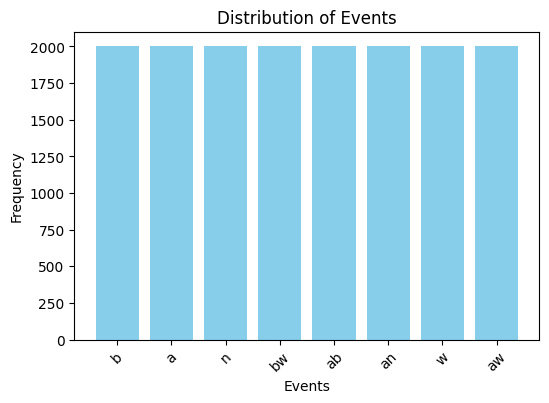

validation dataset event distribution:


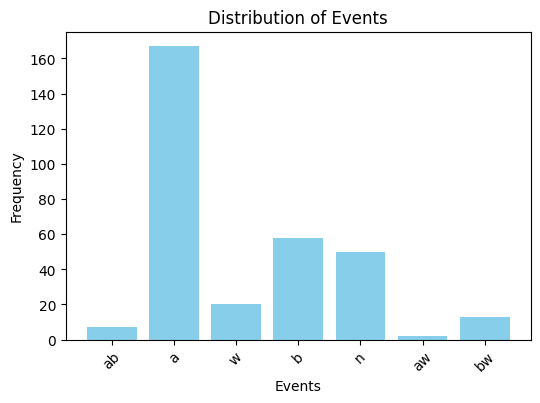

In [31]:
# View the amount of training/validation data and their distributions
print("Amount training dataset", len(X_train_augmented))
print("Amount validation dataset", len(X_val))
print("training dataset event distribution:")

plot_events_distribution(Y_train_augmented)

print("validation dataset event distribution:")
plot_events_distribution(Y_val)

In [32]:
# Display 5 spectrogram examples of each of the different types of targets
# in each case view the spectrogram and display the target. Note that some
# events are multi-label, so you need to show 5 examples for each different
# multi/single event
def display_spectrograms(X_train_augmented, Y,sr=16000, hop_length=512, num_examples=5):
    labels = ['a', 'b', 'n', 'w']
    X_train_augmented = np.array([spec if spec.ndim == 3 else spec[..., np.newaxis] for spec in X_train_augmented])

    unique_labels = np.unique([','.join(np.array(labels)[row.astype(bool)]) for row in Y])

    label_examples = {label: [] for label in unique_labels}

    for spectrogram, label in zip(X_train_augmented, Y):
        label_str = ','.join(np.array(labels)[label.astype(bool)])
        if label_str in label_examples and len(label_examples[label_str]) < num_examples:
            label_examples[label_str].append(spectrogram)

    num_labels = len(label_examples)
    fig, axes = plt.subplots(num_labels, num_examples, figsize=(num_examples * 4, num_labels * 3))
    axes = np.atleast_2d(axes)

    for row, (label_str, examples) in enumerate(label_examples.items()):
        for col in range(num_examples):
            ax = axes[row, col] if num_labels > 1 else axes[col]
            if col < len(examples):
                spec = examples[col][..., 0]

                num_time_steps = spec.shape[1]
                num_freq_bins = spec.shape[0]
                duration = (num_time_steps * hop_length) / sr
                frequencies = np.linspace(0, sr / 2, num_freq_bins)
                times = np.linspace(0, duration, num_time_steps)
                img = ax.imshow(spec, cmap='inferno', origin='lower', aspect='auto',
                                extent=[times[0], times[-1], frequencies[0], frequencies[-1]])
                ax.set_title(f"Label: {label_str}")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Frequency (Hz)")
                fig.colorbar(img, ax=ax, format="%+2.0f dB")
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.show()



display_spectrograms(X_train_augmented, Y_train_augmented)


Output hidden; open in https://colab.research.google.com to view.

In [33]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Input(shape=(X_spectrograms.shape[1], X_spectrograms.shape[2], 1)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(Y.shape[1], activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 155, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 155, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 35, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,376,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,650,308 (6.30 MB)

 Trainable params: 1,650,244 (6.30 MB)

 Non-trainable params: 64 (256.00 B)

In [34]:
del X_train
del Y_train
del X_spectrograms
del Y

In [35]:
# del model

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


filepath="my_data.keras"


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

callbacks_list = [checkpoint, early_stopping,lr_reduction]

history = model.fit(
    X_train_augmented,
    Y_train_augmented,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=192,
    callbacks=callbacks_list
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4823 - loss: 4.0932 
Epoch 1: val_loss improved from inf to 0.94676, saving model to my_data.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 990s 12s/step - accuracy: 0.4832 - loss: 4.0714 - val_accuracy: 0.6751 - val_loss: 0.9468 - learning_rate: 0.0010
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6602 - loss: 0.5322 
Epoch 2: val_loss improved from 0.94676 to 0.71726, saving model to my_data.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 1045s 12s/step - accuracy: 0.6602 - loss: 0.5316 - val_accuracy: 0.6782 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7060 - loss: 0.3491 
Epoch 3: val_loss improved from 0.71726 to 0.60033, saving model to my_data.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 1034s 12s/step - accuracy: 0.7060 - loss: 0.3489 - val_accuracy: 0.6435 - val_loss: 0.6003 - learning_rate: 0.0010
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7219 - loss: 0

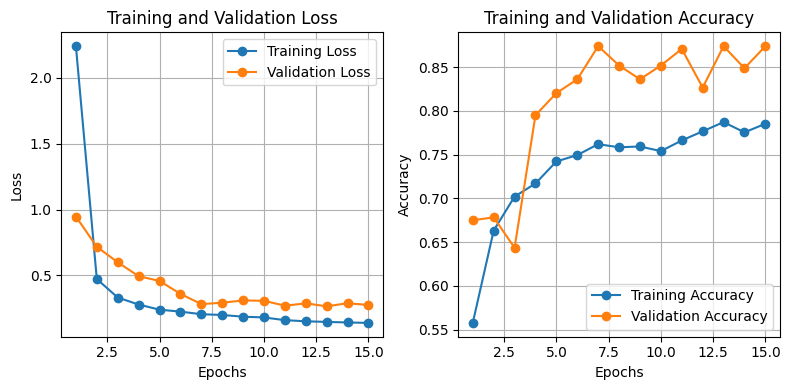

In [37]:
import matplotlib.pyplot as plt


def plot_training_history(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    if 'accuracy' in history.history:
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)


    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.savefig('training_loss_accuracy2.pdf')
    plt.show()


plot_training_history(history)


In [38]:
# Save the model weights to your disk once you have your best model
model.save_weights('/content/drive/MyDrive/Project_Ecology/my_data.weights.h5')

In [45]:
model.load_weights('/content/drive/MyDrive/Project_Ecology/my_data.weights.h5')

# **PREDICTIONS**

In [39]:
def grouped_predictions(predictions, timestamps, segment_duration=5):

    predictions_array = np.array(predictions)


    indices = np.arange(len(predictions_array))


    groups = []
    current_start = indices[0]
    current_label = predictions_array[0]
    grouped_indices = []

    for i in range(1, len(indices)):
        if predictions_array[i] == current_label:
            continue
        else:

            groups.append((current_start, indices[i-1], current_label))
            grouped_indices.append(list(range(current_start, indices[i])))
            current_start = indices[i]
            current_label = predictions_array[i]

    groups.append((current_start, indices[-1], current_label))
    grouped_indices.append(list(range(current_start, indices[-1] + 1)))

    grouped_df = pd.DataFrame(groups, columns=['start_index', 'end_index', 'label'])
    grouped_df['start_time'] = grouped_df['start_index'] * segment_duration
    grouped_df['end_time'] = (grouped_df['end_index'] + 1) * segment_duration
    print("\nGrouped Predictions:")
    for _, row in grouped_df.iterrows():
        print(f"Label: {row['label']}, Start Time: {row['start_time']}s, End Time: {row['end_time']}s")


    return grouped_df

In [40]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd

label_colors = {
    'a': 'blue',
    'b': 'green',
    'n': 'gray',
    'w': 'orange',
    'ab': 'purple',
    'an': 'cyan',
    'aw': 'yellow',
    'bw': 'red',
}

def predict_single_file(test_file_name, test_path, model):
    print(f'Reading audio file: {test_file_name}...')
    audio_amps, original_sample_rate = librosa.load(f"{test_path}/{test_file_name}", sr=None)

    downsample_rate = 16000
    amplitudes = librosa.resample(audio_amps, orig_sr=original_sample_rate, target_sr=downsample_rate)
    sample_rate = downsample_rate
    segment_duration = 5
    start_values = np.arange(0, len(amplitudes) / sample_rate - segment_duration, step=segment_duration)
    end_values = start_values + segment_duration

    amplitudes_to_predict = []

    # segment to spectrogram
    for i in range(len(start_values)):
        s, e = int(start_values[i] * sample_rate), int(end_values[i] * sample_rate)
        segment_audio = amplitudes[s:e]
        spectrogram_image = audio_to_spec(segment_audio, n_fft=2048, hop_length=512, n_mels=128)
        amplitudes_to_predict.append(spectrogram_image)

    amplitudes_to_predict = np.asarray(amplitudes_to_predict)
    print(f'Prediction shape: {amplitudes_to_predict.shape}')

    # predictions
    softmax_predictions = model.predict(amplitudes_to_predict)
    print('done predicting')

    threshold = 0.5
    predictions = []
    label_map = {
        '1000': 'a',
        '0100': 'b',
        '0010': 'n',
        '0001': 'w',
        '1100': 'ab',
        '1001': 'aw',
        '0011': 'bw',
        '1010': 'an',
        '0110': 'bn',
        '1110': 'abn',
        '1111': 'abnw',
        '0000': 'n'
    }


    for i, pred in enumerate(softmax_predictions):
        binary_pred = ''.join(['1' if prob > threshold else '0' for prob in pred])
        predictions.append(binary_pred)

        label = label_map.get(binary_pred, None)

        if label:
            print(f"segment {i} -> probability: {pred} -> binary: {binary_pred} -> label: {label}")


    mapped_labels = [label_map.get(pred, None) for pred in predictions]
    mapped_labels = [label for label in mapped_labels if label is not None]

    timestamps = np.arange(0, len(mapped_labels) * segment_duration, segment_duration)

    grouped_df = grouped_predictions(mapped_labels, timestamps)

    plt.figure(figsize=(12, 8))

    for _, row in grouped_df.iterrows():
        plt.barh(row['label'], row['end_time'] - row['start_time'], left=row['start_time'], height=0.5,
                 color=label_colors[row['label']])

    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in label_colors.values()]
    labels = ['anthropony(a)', 'biophony(b)', 'silence (n)', 'wind (w)', 'anthropony + biophony (ab)',
              'anthropony + silence (an)', 'anthropony + wind (aw)', 'biophony + wind (bw)']
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=16)

    plt.xlabel('time(s)')
    plt.ylabel('Event Type')
    plt.title(f'visualization of predicted acoustic events for {test_file_name}')
    plt.grid(True)
    plt.savefig(f'{test_file_name}_prediction2.pdf')
    plt.show()


In [41]:
# do not modify
test3 = '1APBxL5lyAX_cV0U5BLkz3BSrhUKm7zaB'
test4 = '1ROfjh47uZtnK-HVNiwcbAECC6HIwYtmk'
test5 = '144H3yHYIxHH6v_JY_-EP2--X5U7PxwbX'
test6 = '1I_GeHEt0EdoAptUjh9obDOoXXNUm1Rwq'
test7 = '1AdLXsvvbgSPSI6IrvDY0cSDIpccbtx4B'
test8 = '1nKdVkDEV4v8RTONoPQR0xiepc6B6_JSi'
test9 = '13k_o2W62I9aQRWmubT-U5-lQcRm4w6oi'
test10 = '1z-60L-piAo96URDKpfY7jW3V0UWiHfAt'

In [46]:
# do not modify
downloaded = drive.CreateFile({'id':test3})
downloaded.GetContentFile('20241113_102700_AIMS.WAV')

downloaded = drive.CreateFile({'id':test4})
downloaded.GetContentFile('20241113_092100_AIMS.WAV')

downloaded = drive.CreateFile({'id':test5})
downloaded.GetContentFile('20241113_022700_CC.WAV')

downloaded = drive.CreateFile({'id':test6})
downloaded.GetContentFile('20241112_061800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test7})
downloaded.GetContentFile('20241112_035100.WAV')

downloaded = drive.CreateFile({'id':test8})
downloaded.GetContentFile('20241112_024800.WAV')

downloaded = drive.CreateFile({'id':test9})
downloaded.GetContentFile('20241112_024800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test10})
downloaded.GetContentFile('20241111_224500.WAV')

Predict on these files. You will be assessed on how well your model performs on these files and how informative your plot was at telling a story about what sounds happened in this file.

Reading audio file: 20241111_224500.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step
done predicting
segment 0 -> probability: [2.2320237e-02 9.7584957e-04 9.8841149e-01 6.3880853e-04] -> binary: 0010 -> label: n
segment 1 -> probability: [1.9491509e-02 7.6319982e-04 9.8621315e-01 1.5968843e-03] -> binary: 0010 -> label: n
segment 2 -> probability: [0.49042907 0.00175478 0.8613509  0.00149309] -> binary: 0010 -> label: n
segment 3 -> probability: [9.8968071e-01 4.9807981e-02 3.5645213e-02 6.4767490e-04] -> binary: 1000 -> label: a
segment 4 -> probability: [0.9794334  0.29639408 0.01559448 0.00643814] -> binary: 1000 -> label: a
segment 5 -> probability: [0.02204862 0.00874517 0.9571994  0.00386988] -> binary: 0010 -> label: n
segment 6 -> probability: [8.1710719e-02 2.0329704e-04 9.7536534e-01 8.1871514e-04] -> binary: 0010 -> label: n
segment 7 -> probability: [6.0654117e-04 3.2620085e-04 9.9833310e-01 3.0066937e-04] -> binary: 0010 -> label: n
segment 

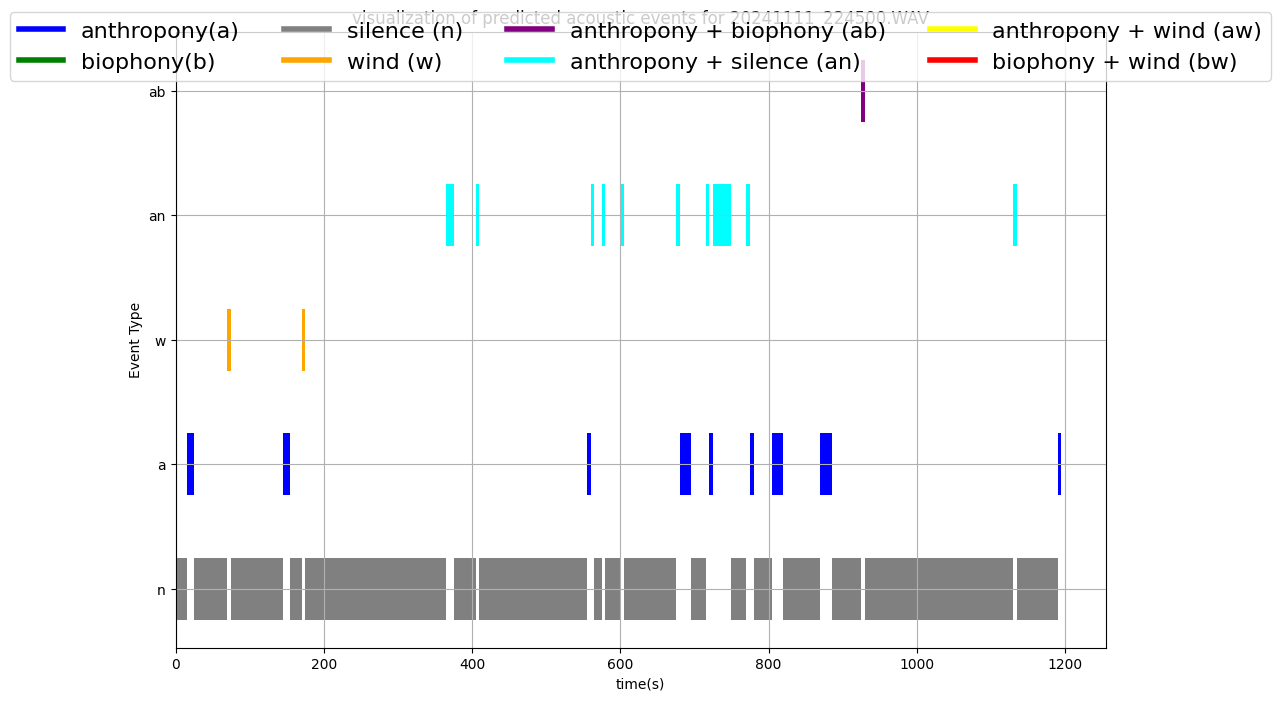

In [47]:
# do not modify
test_path = '.'
test_file_name = '20241111_224500.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241112_024800.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step
done predicting
segment 0 -> probability: [1.4148077e-02 9.9346393e-01 1.3471754e-05 1.3967886e-04] -> binary: 0100 -> label: b
segment 1 -> probability: [3.6704954e-02 9.9466455e-01 2.0510035e-05 1.2707381e-04] -> binary: 0100 -> label: b
segment 2 -> probability: [5.7291379e-03 9.9828112e-01 3.1118918e-07 3.1911843e-06] -> binary: 0100 -> label: b
segment 3 -> probability: [3.5309130e-03 9.9261111e-01 2.3911374e-04 3.3659164e-03] -> binary: 0100 -> label: b
segment 4 -> probability: [9.2448401e-01 9.9073905e-01 8.5662774e-05 2.5474812e-05] -> binary: 1100 -> label: ab
segment 5 -> probability: [1.5008953e-01 9.6172082e-01 8.8005236e-06 2.0827193e-04] -> binary: 0100 -> label: b
segment 6 -> probability: [1.3391020e-02 9.9890703e-01 2.0987547e-06 4.9725437e-05] -> binary: 0100 -> label: b
segment 7 -> probability: [7.5303622e-02 9.9908495e-01 1.4882060e-05 1.6351612e-04]

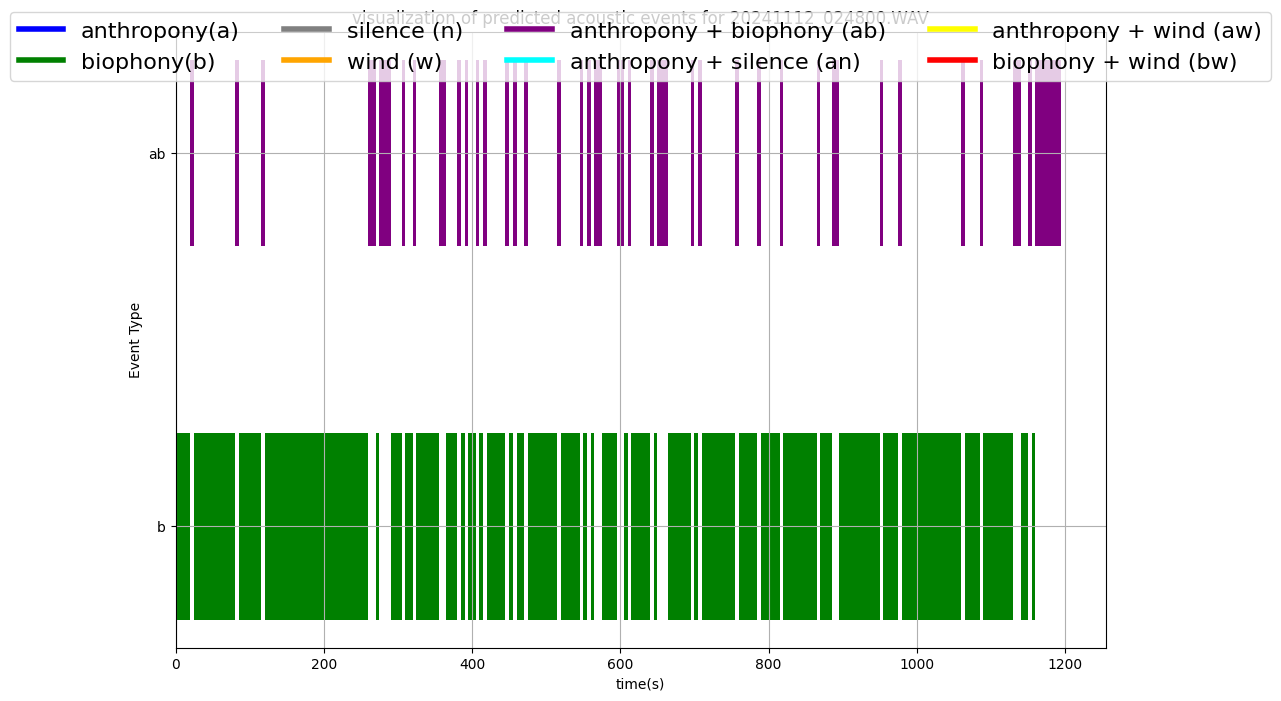

In [48]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241112_024800_AIMS.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step
done predicting
segment 0 -> probability: [1.4101643e-02 9.8837560e-01 2.5736325e-04 2.5289273e-02] -> binary: 0100 -> label: b
segment 1 -> probability: [0.4023391  0.5684236  0.00575274 0.02890889] -> binary: 0100 -> label: b
segment 2 -> probability: [3.1588752e-02 9.7583133e-01 6.3392363e-04 7.2636142e-02] -> binary: 0100 -> label: b
segment 3 -> probability: [0.50373244 0.46899295 0.01054954 0.05585165] -> binary: 1000 -> label: a
segment 4 -> probability: [0.32403994 0.7670224  0.00547587 0.00576229] -> binary: 0100 -> label: b
segment 5 -> probability: [9.5925210e-03 9.7531235e-01 4.9457210e-04 1.4887252e-01] -> binary: 0100 -> label: b
segment 6 -> probability: [0.19902398 0.3977623  0.00554723 0.06813081] -> binary: 0000 -> label: n
segment 7 -> probability: [0.0523618  0.96568    0.00229724 0.04715665] -> binary: 0100 -> label: b
segment 8 -> probability: [

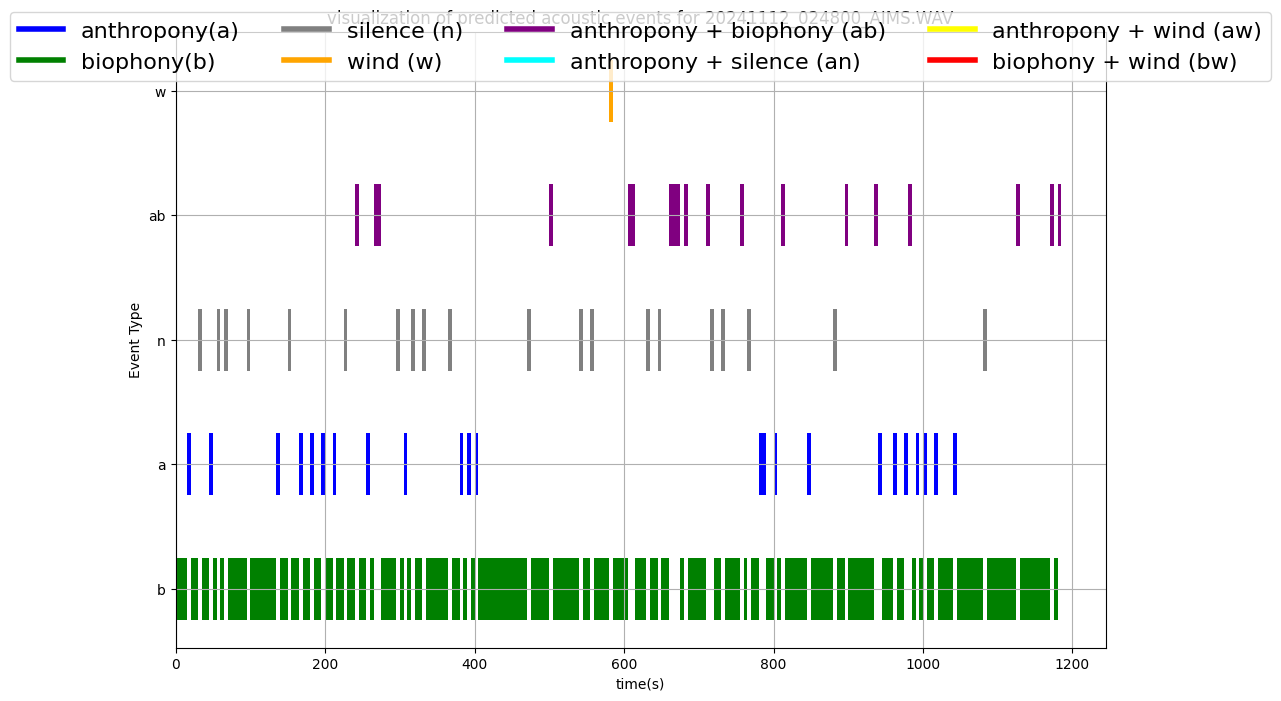

In [49]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241112_061800_AIMS.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step
done predicting
segment 0 -> probability: [0.10423148 0.8034347  0.01166907 0.11435974] -> binary: 0100 -> label: b
segment 1 -> probability: [0.91869277 0.664178   0.00456947 0.00200338] -> binary: 1100 -> label: ab
segment 2 -> probability: [0.5253467  0.76904064 0.00949573 0.0075644 ] -> binary: 1100 -> label: ab
segment 3 -> probability: [0.01917797 0.9290745  0.00703431 0.06551301] -> binary: 0100 -> label: b
segment 4 -> probability: [0.9775385  0.14834069 0.00397223 0.00198431] -> binary: 1000 -> label: a
segment 5 -> probability: [0.41360858 0.8508664  0.00726532 0.00497854] -> binary: 0100 -> label: b
segment 6 -> probability: [0.8236811  0.64132655 0.00316556 0.00124256] -> binary: 1100 -> label: ab
segment 7 -> probability: [0.31769446 0.7951416  0.00788636 0.01291514] -> binary: 0100 -> label: b
segment 8 -> probability: [9.7735488e-01 2.4117336e-01 2.975

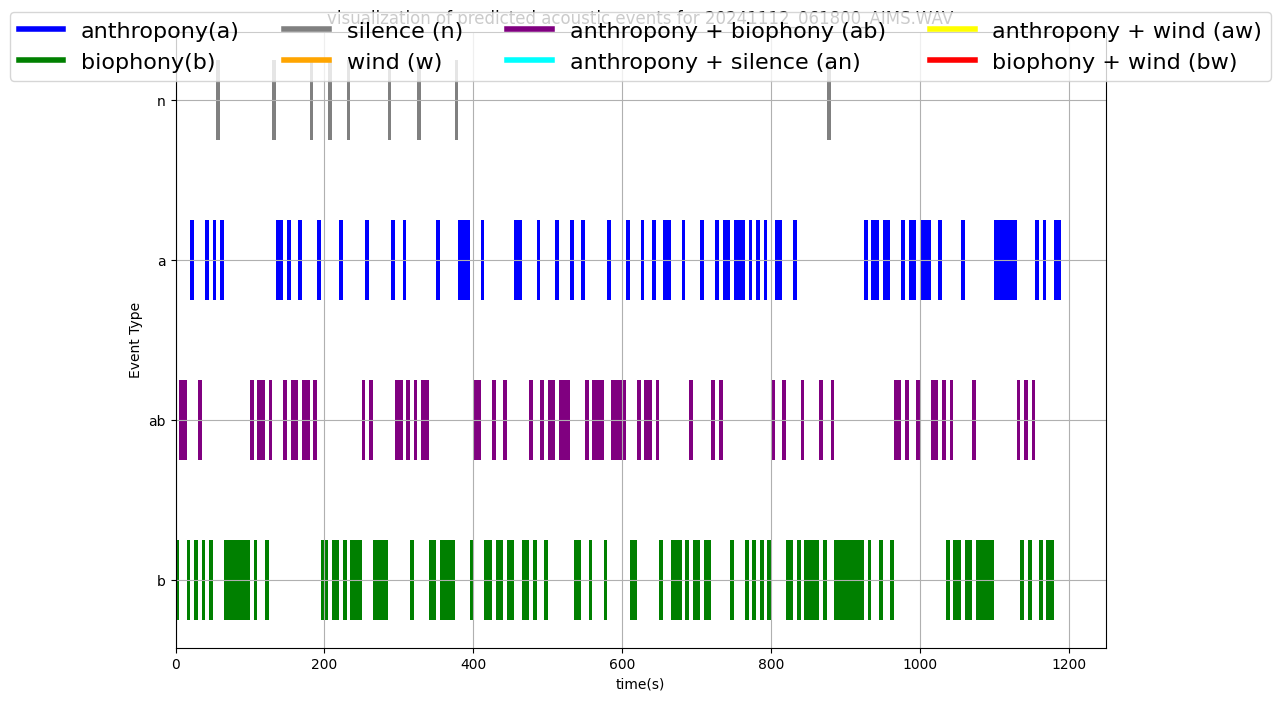

In [50]:
# do not modify
test_path = '.'
test_file_name = '20241112_061800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241112_035100.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step
done predicting
segment 0 -> probability: [4.0280815e-02 9.9872196e-01 5.5387951e-05 4.0108571e-03] -> binary: 0100 -> label: b
segment 1 -> probability: [2.9330498e-02 9.9710739e-01 5.1232186e-05 3.4028682e-04] -> binary: 0100 -> label: b
segment 2 -> probability: [7.4807152e-02 9.9897707e-01 3.0014258e-05 8.1814436e-04] -> binary: 0100 -> label: b
segment 3 -> probability: [2.3520669e-02 2.7981098e-03 9.4653487e-01 1.6957327e-05] -> binary: 0010 -> label: n
segment 4 -> probability: [4.3855286e-01 2.6236682e-03 9.4496685e-01 2.6284551e-06] -> binary: 0010 -> label: n
segment 5 -> probability: [9.9698305e-01 1.6618624e-01 3.6486068e-03 3.9881590e-05] -> binary: 1000 -> label: a
segment 6 -> probability: [3.1844003e-03 9.7926033e-01 1.3786256e-06 4.8910536e-02] -> binary: 0100 -> label: b
segment 7 -> probability: [4.3837830e-01 9.4595975e-01 6.8092399e-05 1.4731665e-02] 

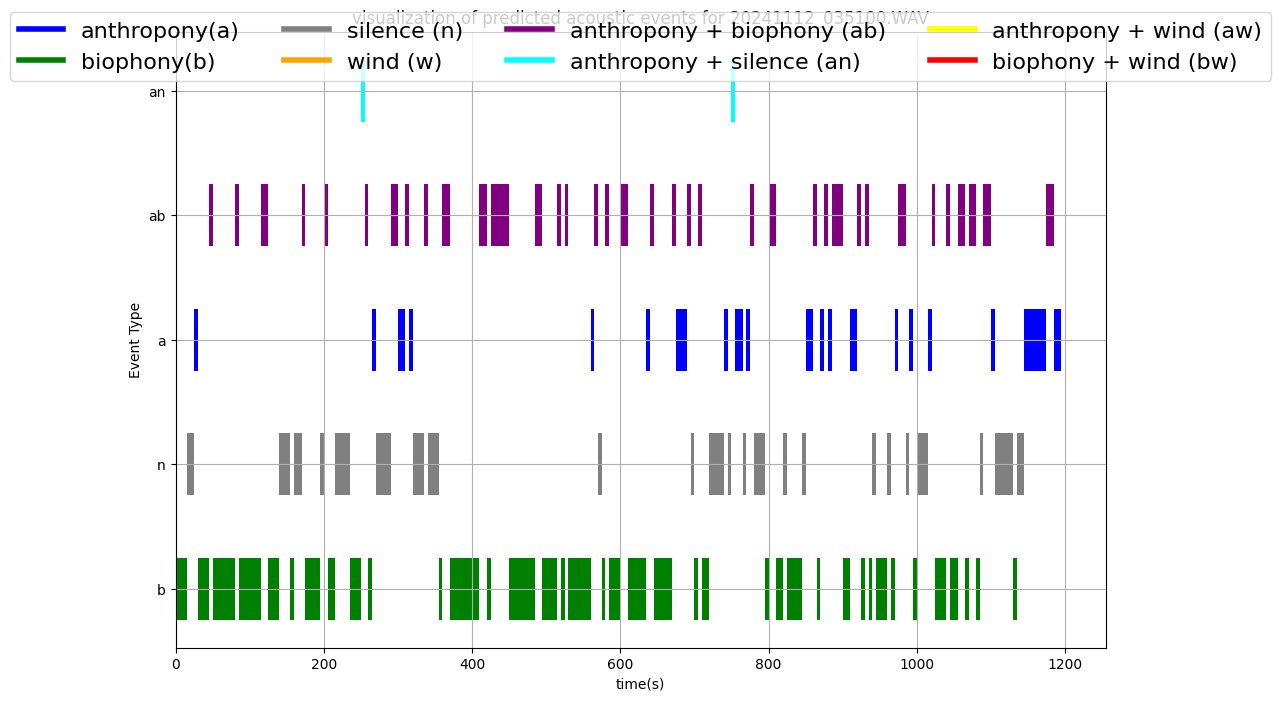

In [51]:
# do not modify
test_path = '.'
test_file_name = '20241112_035100.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241113_022700_CC.WAV...
Prediction shape: (239, 128, 157)
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step
done predicting
segment 1 -> probability: [0.00182927 0.93220556 0.0027415  0.41555405] -> binary: 0100 -> label: b
segment 2 -> probability: [1.2237893e-02 9.8265976e-01 5.7542402e-05 5.9072405e-02] -> binary: 0100 -> label: b
segment 4 -> probability: [1.5106065e-04 6.2813535e-02 5.7856773e-04 9.9794161e-01] -> binary: 0001 -> label: w
segment 5 -> probability: [7.9352045e-03 9.5850623e-01 9.1143098e-04 2.4623498e-02] -> binary: 0100 -> label: b
segment 6 -> probability: [1.8418572e-03 9.9479282e-01 1.6541504e-04 5.6008279e-02] -> binary: 0100 -> label: b
segment 7 -> probability: [0.01866645 0.9679201  0.00128711 0.01899023] -> binary: 0100 -> label: b
segment 9 -> probability: [1.7584562e-04 9.9169481e-01 1.0850759e-04 2.8348368e-01] -> binary: 0100 -> label: b
segment 10 -> probability: [9.7622731e-05 2.2228454e-01 4.2021084e-03 9.6471733e-01] -> binary: 0001 -> l

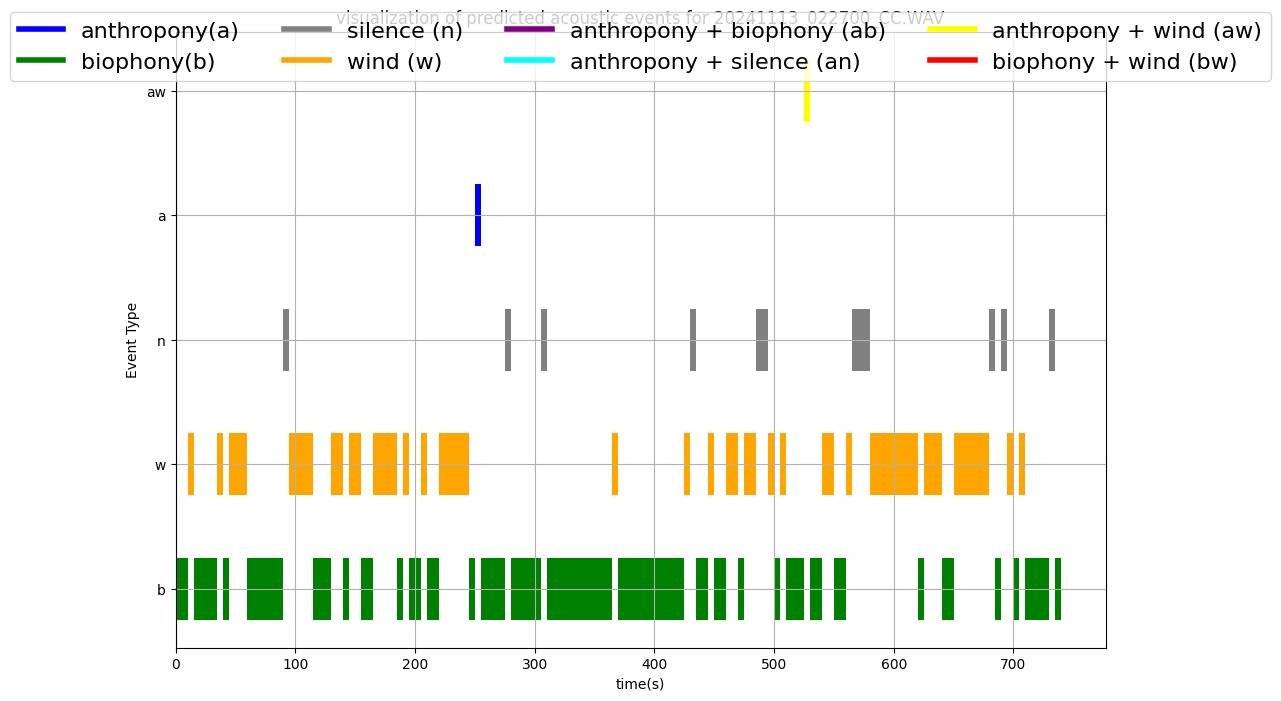

In [52]:
# do not modify
test_path = '.'
test_file_name = '20241113_022700_CC.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241113_092100_AIMS.WAV...
Prediction shape: (119, 128, 157)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
done predicting
segment 0 -> probability: [9.9408424e-01 1.0907020e-02 3.1032087e-05 8.3473496e-05] -> binary: 1000 -> label: a
segment 1 -> probability: [9.9610358e-01 2.1446045e-03 8.8515593e-04 1.6869778e-04] -> binary: 1000 -> label: a
segment 2 -> probability: [9.9969691e-01 3.5783604e-03 7.8001154e-05 3.4943969e-06] -> binary: 1000 -> label: a
segment 3 -> probability: [9.9999899e-01 5.8411122e-05 1.8624196e-05 3.3229408e-10] -> binary: 1000 -> label: a
segment 4 -> probability: [9.9996841e-01 2.6729747e-04 2.7493055e-05 4.7255856e-08] -> binary: 1000 -> label: a
segment 5 -> probability: [9.9996138e-01 4.3249855e-04 1.8814852e-05 3.9707064e-08] -> binary: 1000 -> label: a
segment 6 -> probability: [9.9996036e-01 3.3958777e-04 1.2519945e-04 7.6110688e-08] -> binary: 1000 -> label: a
segment 7 -> probability: [9.9994445e-01 4.4960878e-04 5.0873886e-04 1.7300511e

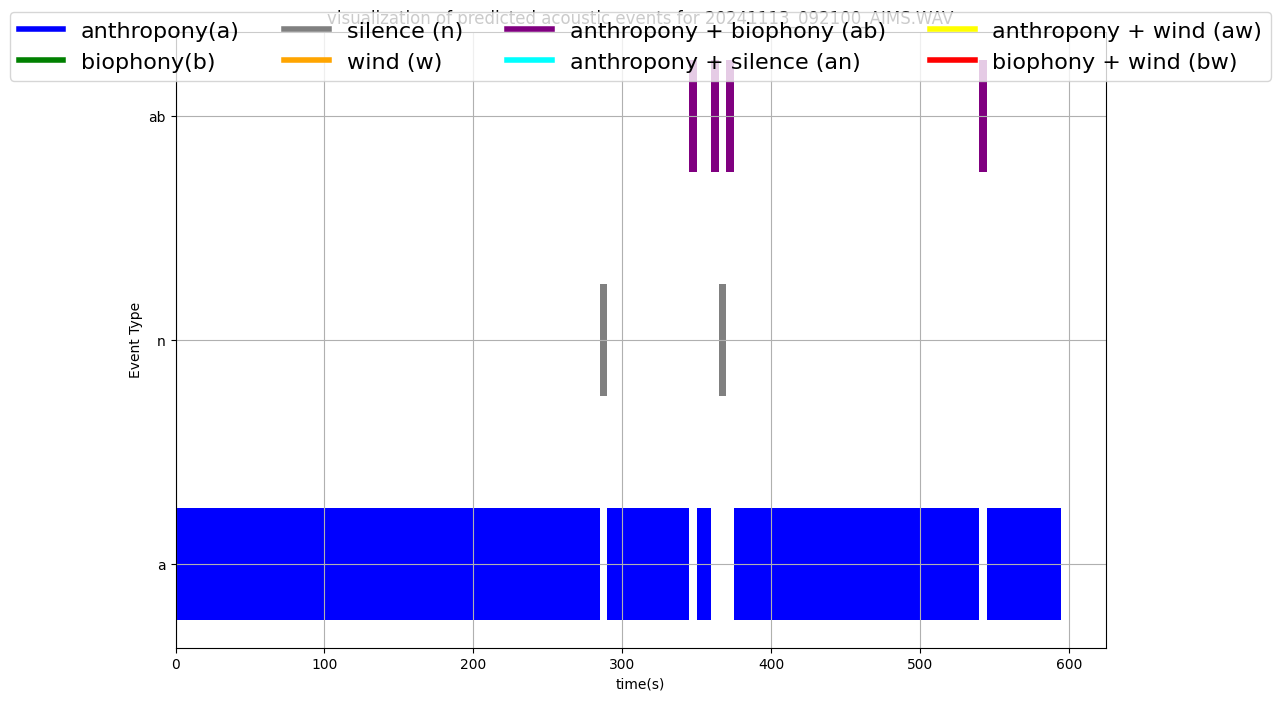

In [53]:
# do not modify
test_path = '.'
test_file_name = '20241113_092100_AIMS.WAV'

predict_single_file(test_file_name, test_path, model)

Reading audio file: 20241113_102700_AIMS.WAV...
Prediction shape: (119, 128, 157)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
done predicting
segment 0 -> probability: [9.8582286e-01 9.1754901e-04 1.9468514e-02 2.0045256e-04] -> binary: 1000 -> label: a
segment 1 -> probability: [9.8626912e-01 3.6166115e-03 9.3157766e-03 3.1562487e-04] -> binary: 1000 -> label: a
segment 2 -> probability: [9.9557841e-01 1.4301116e-03 1.1235300e-02 6.1052997e-04] -> binary: 1000 -> label: a
segment 3 -> probability: [9.8861545e-01 1.8147369e-03 2.7606815e-02 2.0206757e-04] -> binary: 1000 -> label: a
segment 4 -> probability: [8.4381491e-01 1.7616671e-03 1.2276143e-01 6.6673332e-05] -> binary: 1000 -> label: a
segment 5 -> probability: [9.5563620e-01 3.6271096e-03 1.8594993e-02 4.2407820e-04] -> binary: 1000 -> label: a
segment 6 -> probability: [5.9674108e-01 5.8456911e-03 2.3312962e-01 1.3288374e-04] -> binary: 1000 -> label: a
segment 7 -> probability: [9.9231350e-01 4.5966590e-03 1.4706558e-02 1.5851176e

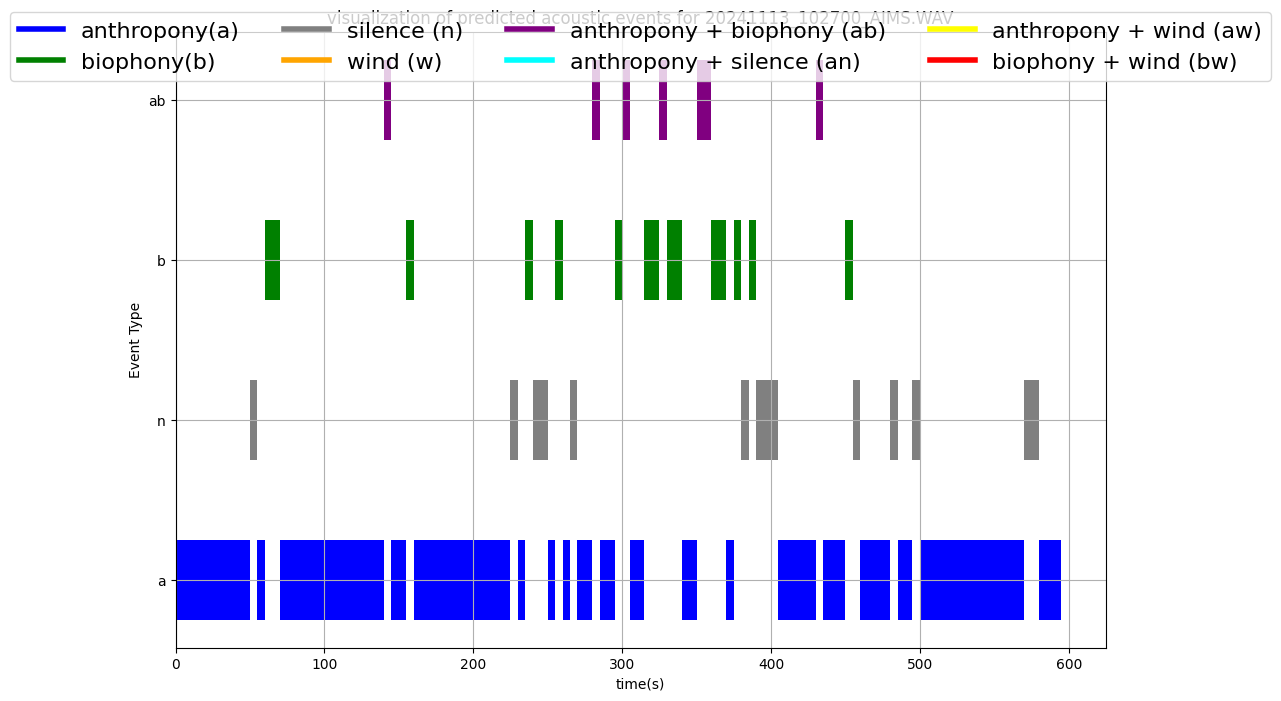

In [54]:
# do not modify
test_path = '.'
test_file_name = '20241113_102700_AIMS.WAV'

predict_single_file(test_file_name, test_path, model)